In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import time

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train.csv')
test = pd.read_csv('../data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


In [5]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(543516, 39) (543516, 30) (543516, 15) (543516, 15) (543516, 15) (543516, 15) (543516,)
(135880, 39) (135880, 30) (135880, 15) (135880, 15) (135880, 15) (135880, 15) (135880,)
(133992, 39) (133992, 30) (133992, 15) (133992, 15) (133992, 15) (133992, 15) (133992,)


# MS2

In [7]:
df_ms2 = pd.read_csv('df_modeling_211124_result.msms', sep='\t')

In [8]:
print(df_ms2.shape)
df_ms2.head(1)

(2385750, 5)


,Intensities,Masses,Matches,Modified Sequence,Charge
0,0.16607068;0.22559804;1.0;0.10618063;0.1724560...,147.112804167;261.155731167;358.20849516699997...,y1;y2;y3;y4;y5;y6;y7;y8;y9;y10;y11;y12;y13;y14...,QELNEPPKQSTSFLVLQEILESEEKGDPNK,3


In [9]:
def get_ion_type():
    # y1 ~ y29, b1 ~ b29, y1(2+) ~ y29(2+), ... , b1(3+) ~ b29(3+)
    ion_num_arr = list(map(str, range(1, 30)))
    ion_type_arr = ['y', 'b']
    ion_charge_arr = ['', '(2+)', '(3+)']
    ion_arr = []
    for ic in ion_charge_arr:
        for it in ion_type_arr:
            for inum in ion_num_arr:
                ion_arr.append(it+inum+ic)
    return ion_arr

def ms_to_174(intens, matches):
    i = list(map(float, intens.split(';')))
    m = matches.split(';')
    ion_dic = {k:v for k, v in zip(m, i)}

    ion_arr = get_ion_type()
    for ion in ion_arr:
        if ion not in ion_dic:
            ion_dic[ion] = 0
    return ion_dic

def ms_to_29(intens, matches, pep):
    i = list(map(float, intens.split(';')))
    m = matches.split(';')
    ion_dic = {k:v for k, v in zip(m, i)}

    ion_arr = get_ion_type()
    for ion in ion_arr:
        if ion not in ion_dic:
            ion_dic[ion] = 0
    
    # fragmentation part
    ion_y1c = ['y' + str(i) for i in range(1, len(pep))]
    ion_y2c = ['y' + str(i) + '(2+)' for i in range(1, len(pep))]
    ion_y3c = ['y' + str(i) + '(3+)' for i in range(1, len(pep))]
    ion_b1c = ['b' + str(i) for i in range(len(pep)-1, 0, -1)]
    ion_b2c = ['b' + str(i) + '(2+)' for i in range(len(pep)-1, 0, -1)]
    ion_b3c = ['b' + str(i) + '(3+)'  for i in range(len(pep)-1, 0, -1)]
    
    ion_sum = {i:0 for i in range(1, 30)}
    for idx, i in enumerate(range(1, len(pep))):
        y1c = ion_dic[ion_y1c[idx]]
        y2c = ion_dic[ion_y2c[idx]]
        y3c = ion_dic[ion_y3c[idx]]
        b1c = ion_dic[ion_b1c[idx]]
        b2c = ion_dic[ion_b2c[idx]]
        b3c = ion_dic[ion_b3c[idx]]
        
        ion_sum[i] = y1c + y2c + y3c + b1c + b2c + b3c
    
    return list(np.array(sorted(ion_sum.items()))[:, 1])

In [10]:
s = time.time()

p2ms2 = dict()
for i, m, p, c in df_ms2[['Intensities', 'Matches', 'Modified Sequence', 'Charge']].values:
    if p not in p2ms2:
        p2ms2[p] = {k:[0 for _ in range(1, 30)] for k in range(1, 6)}
    p2ms2[p][c] = ms_to_29(i, m, p)

e = time.time()
print('time: ', round(e-s, 2), 'sec')

time:  331.16 sec


In [11]:
pep_to_ms = dict()
for k, v in p2ms2.items():
    tensor = np.array(sorted(v.items()))[:, 1]
    ms2arr = np.concatenate(tensor, axis=None)
    pep_to_ms[k] = ms2arr

/home/bis/miniconda3/envs/TF2.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
h_train = np.array([pep_to_ms[p] for p in train.PEP.values])
c_train = h_train.copy()
h_val = np.array([pep_to_ms[p] for p in val.PEP.values])
c_val = h_val.copy()

In [28]:
h_test = np.array([pep_to_ms[p] for p in test.PEP.values])
c_test = h_test.copy()

# Train

In [13]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

from tensorflow import keras

In [14]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

# high param

In [15]:
BS = 256  # batch_size


# Embedding
pep = tf.keras.layers.Input(shape=((30,)))
pep_embed = tf.keras.layers.Embedding(21, 128, input_length=30, mask_zero=True)(pep)
pep_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_embed)

meta = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
n_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(n)
n_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_embed)

c = tf.keras.layers.Input(shape=((15,)))
c_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(c)
c_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_embed)

m1 = tf.keras.layers.Input(shape=((15,)))
m1_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(m1)
m1_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_embed)

m2 = tf.keras.layers.Input(shape=((15,)))
m2_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(m2)
m2_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_embed)


# LSTM
net_meta = tf.keras.layers.Dense(32, activation='relu')(meta)
net_meta = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_meta)

n_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(n_embed)
n_lstm = tf.keras.layers.Dense(32, activation='relu')(n_lstm)
n_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_lstm)

c_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(c_embed)
c_lstm = tf.keras.layers.Dense(32, activation='relu')(c_lstm)
c_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_lstm)

m1_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(m1_embed)
m1_lstm = tf.keras.layers.Dense(32, activation='relu')(m1_lstm)
m1_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_lstm)

m2_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(m2_embed)
m2_lstm = tf.keras.layers.Dense(32, activation='relu')(m2_lstm)
m2_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_lstm)

h_0 = tf.keras.layers.Input(shape=((145,)))
c_0 = tf.keras.layers.Input(shape=((145,)))
# pep_lstm = tf.keras.layers.LSTM(145, stateful=True, batch_size=(BS, 30, 128))(pep_embed, initial_state=[h_0, c_0])
pep_lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(145))(pep_embed, initial_state=[h_0, c_0, h_0, c_0])
pep_lstm = tf.keras.layers.Dense(128, activation='relu')(pep_lstm)
pep_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_lstm)


# Dense
merge = tf.keras.layers.concatenate([pep_lstm, 
                                     net_meta,
                                     n_lstm,
                                     c_lstm,
                                     m1_lstm,
                                     m2_lstm])
net_merge = tf.keras.layers.Dense(128, activation='relu')(merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)
net_merge = tf.keras.layers.Dense(64, activation='relu')(net_merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_merge)

model_high = tf.keras.Model(inputs=[h_0, c_0, pep, meta, n, c, m1, m2],
                            outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

In [16]:
# # hidden state, cell state 
# model_high.layers[15].states[0] = h_0
# model_high.layers[15].states[1] = c_0

In [17]:
history = model_high.fit([h_train, c_train, pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=100,
                    batch_size=256,
                    validation_data=([h_val, c_val, pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/100
2124/2124 [==============================] - 340s 146ms/step - loss: 3.6758 - accuracy: 0.6178 - val_loss: 0.5176 - val_accuracy: 0.7523
Epoch 2/100
2124/2124 [==============================] - 317s 149ms/step - loss: 0.5329 - accuracy: 0.7446 - val_loss: 0.4721 - val_accuracy: 0.7763
Epoch 3/100
2124/2124 [==============================] - 314s 148ms/step - loss: 0.4850 - accuracy: 0.7719 - val_loss: 0.4552 - val_accuracy: 0.7858
Epoch 4/100
2124/2124 [==============================] - 321s 151ms/step - loss: 0.4634 - accuracy: 0.7830 - val_loss: 0.4459 - val_accuracy: 0.7914
Epoch 5/100
2124/2124 [==============================] - 316s 149ms/step - loss: 0.4526 - accuracy: 0.7905 - val_loss: 0.4354 - val_accuracy: 0.7980
Epoch 6/100
2124/2124 [==============================] - 316s 149ms/step - loss: 0.4408 - accuracy: 0.7980 - val_loss: 0.4276 - val_accuracy: 0.8036
Epoch 7/100
2124/2124 [==============================] - 322s 152ms/step - loss: 0.4323 - accuracy: 0.8036

Epoch 56/100
2124/2124 [==============================] - 325s 153ms/step - loss: 0.3446 - accuracy: 0.8473 - val_loss: 0.3849 - val_accuracy: 0.8305
Epoch 57/100
2124/2124 [==============================] - 317s 149ms/step - loss: 0.3420 - accuracy: 0.8486 - val_loss: 0.3843 - val_accuracy: 0.8314
Epoch 58/100
2124/2124 [==============================] - 330s 156ms/step - loss: 0.3416 - accuracy: 0.8486 - val_loss: 0.3851 - val_accuracy: 0.8303
Epoch 59/100
2124/2124 [==============================] - 332s 156ms/step - loss: 0.3397 - accuracy: 0.8498 - val_loss: 0.3849 - val_accuracy: 0.8309
Epoch 60/100
2124/2124 [==============================] - 326s 153ms/step - loss: 0.3384 - accuracy: 0.8499 - val_loss: 0.3851 - val_accuracy: 0.8311
Epoch 61/100
2124/2124 [==============================] - 320s 151ms/step - loss: 0.3368 - accuracy: 0.8520 - val_loss: 0.3856 - val_accuracy: 0.8294
Epoch 62/100
2124/2124 [==============================] - 322s 152ms/step - loss: 0.3361 - accuracy:

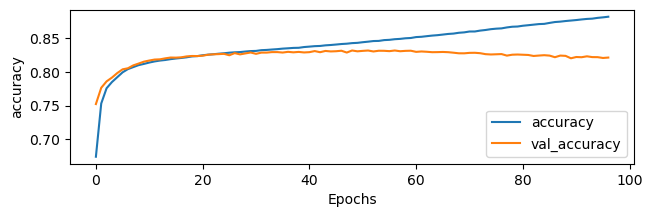

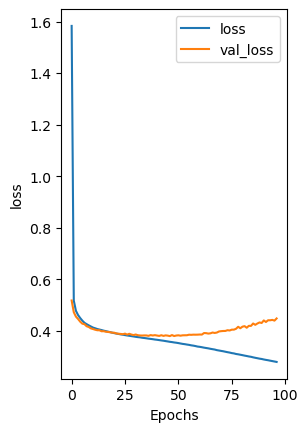

In [18]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

In [29]:
test_loss, test_acc = model_high.evaluate([h_test, c_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4188/4188 [==============================] - 228s 54ms/step - loss: 0.4293 - accuracy: 0.8217
Test Loss: 0.42931556701660156
Test Accuracy: 0.8217281699180603


              precision    recall  f1-score   support

           0       0.85      0.78      0.81     66996
           1       0.80      0.87      0.83     66996

    accuracy                           0.82    133992
   macro avg       0.82      0.82      0.82    133992
weighted avg       0.82      0.82      0.82    133992

rf auc : 0.9008336015587208


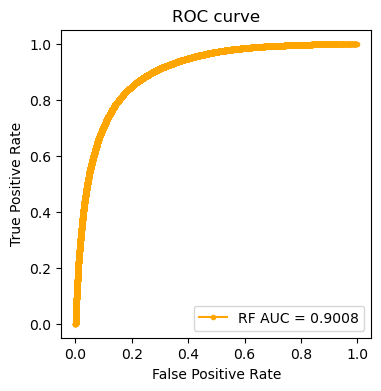

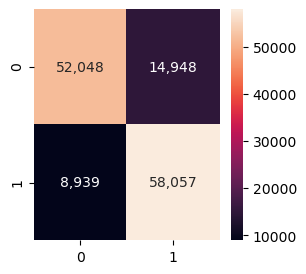

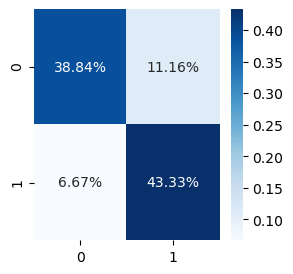

In [30]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([h_test, c_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([h_test, c_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [199]:
# # Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model_high.save("compareModel/2021KSBi_multi_ms2/")

# # It can be used to reconstruct the model identically.
# model_high_re = keras.models.load_model("compareModel/2021KSBi_multi_ms2/")